## Brain Tumor Detection (MRI)

In [1]:
import numpy as np 
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
# DataLoader used for crating minibatches (for faster iterations)
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import sys
import cv2

## Reading the images 

In [2]:
tumor = []
path = './brain_tumor_dataset/yes/*.jpg'
#iterating through the images
for i in glob.iglob(path):
    img = cv2.imread(i)
    img= cv2.resize(img, (128,128)) #creating homogenous image dataset
    r,g,b = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

In [3]:
healthy = []
path = './brain_tumor_dataset/no/*.jpg'
#iterating through the images
for i in glob.iglob(path):
    img = cv2.imread(i)
    img= cv2.resize(img, (128,128)) #creating homogenous image dataset
    r,g,b = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
tumor= np.array(tumor)
healthy = np.array(healthy)

In [5]:
# Checking the shape 
tumor.shape

(154, 128, 128, 3)

In [6]:
healthy.shape

(91, 128, 128, 3)

### Visualizing Brain MRI images

In [7]:
def plot_rand (healthy, tumor, num=5):
    healthy_img= healthy[np.random.choice(healthy.shape[0], num, replace= False)]
    tumor_img= tumor[np.random.choice(tumor.shape[0], num, replace= False)]
    
    plt.figure(figsize=(16,9))
    for f in range(num):
        plt.subplot(1, num, f+1)
        plt.title('Healthy_Brain')
        plt.imshow(healthy_img[f])

    
    plt.figure(figsize=(16,9))
    for f in range(num):
        plt.subplot(1, num, f+1)
        plt.title('Tumor_Brain')
        plt.imshow(tumor_img[f])

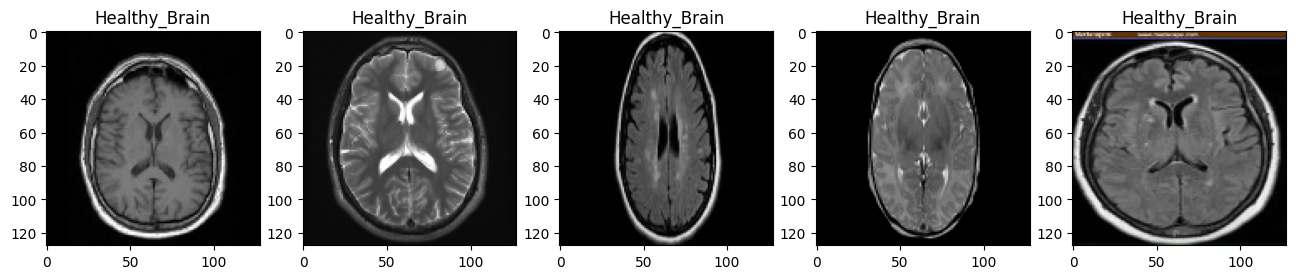

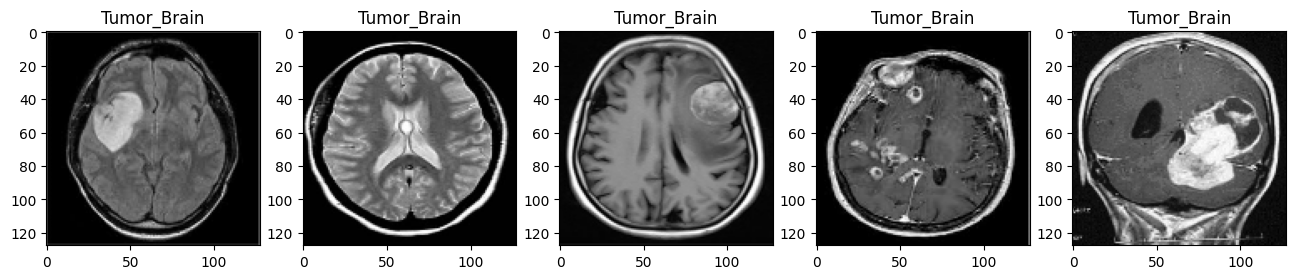

In [8]:
plot_rand(healthy, tumor)

### Creating torch dataset class

In [9]:
## Parent Class
class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

### Creating custom MRI class 

In [10]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        path = './brain_tumor_dataset/yes/*.jpg'
        #iterating through the images
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img= cv2.resize(img, (128,128)) #creating homogenous image dataset
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            tumor.append(img)
        path = './brain_tumor_dataset/no/*.jpg'
        #iterating through the images
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img= cv2.resize(img, (128,128)) #creating homogenous image dataset
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            healthy.append(img)
        #our images
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype= np.float32)

        #our labels
        tumor_label = np.ones(tumor.shape[0], dtype= np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype= np.float32)

        #concatenate
        self.images=np.concatenate((tumor, healthy),axis =0) 
        # axis =0 meaning --> d1= [2,4,1,3] d2=[5,4,1,3] :: d = d1 concat d2 --> [7,4,1,3] {just add the first axis value :) }
        self.labels= np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample= {'image':self.images[index], 'label':self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri= MRI()
mri.normalize()

## Create a dataloader

In [12]:
names= {0:'Healthy_Brain', 1:'Tumor_Brain'}
dataloader = DataLoader(mri, shuffle= True)

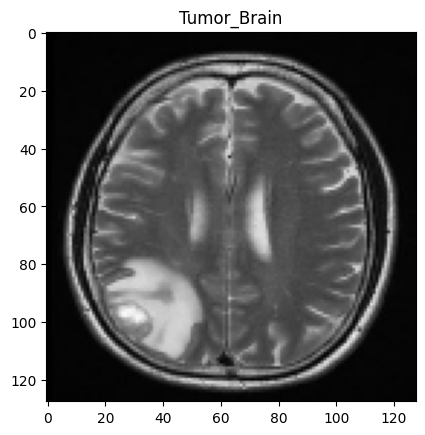

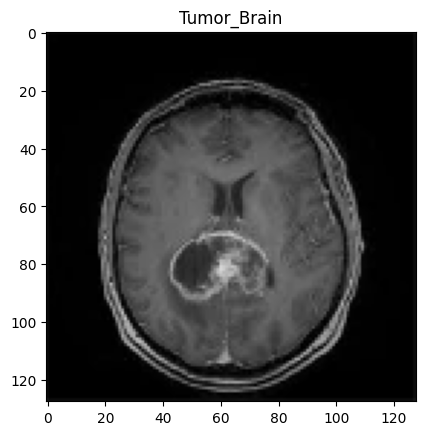

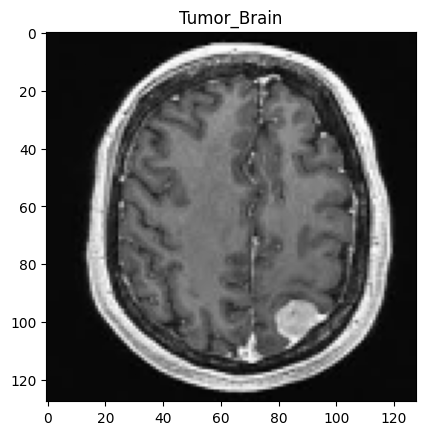

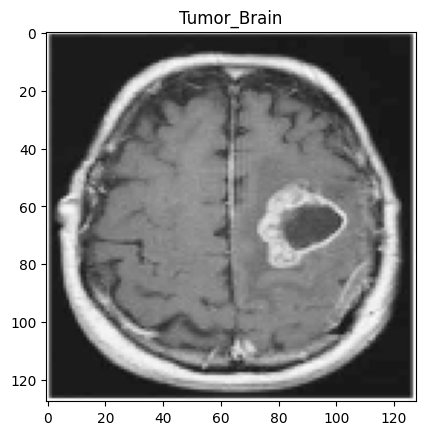

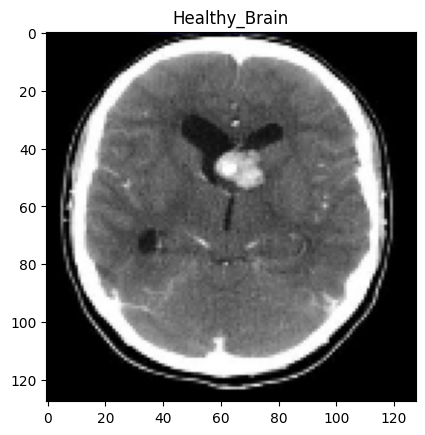

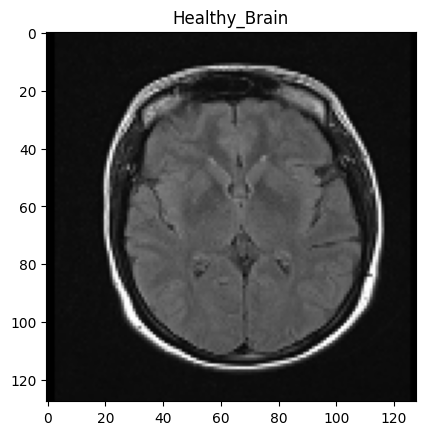

In [13]:
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

## Creating a CNN model

<center><img src="./notebook_imgs/CNN_model.png" /></center>

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride= 5), 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), #output of prev conv_layer is now the input of this layer 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride= 5)
        )
        
        #fully connected layers
        self.fc_model = nn.Sequential( 
            nn.Linear(in_features = 256, out_features= 120), #Logic explained in block below
            nn.Tanh(), 
            nn.Linear(in_features = 120, out_features= 84), 
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features= 1)
        )

    def forward(self, x):
        x= self.cnn_model(x)
        x= x.view(x.size(0), -1) #flattening the 2D array:: to understand this go through block below 
        x= self.fc_model(x)
        x= F.sigmoid(x)


        return x

### Logic behind the numbers:

$$n_{out}= ceil[\frac{n_{in}+2p -f}s +1]$$

#### In the initial state:
<center><img src="./notebook_imgs/just a slight note.gif" /></center>

and on further going through, we get to the point where we encounter $$4×4×16 = 256$$ layers till we reach model.Sequential 

### Looking into the parameters in the model

In [25]:
model = CNN()

In [27]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

#### Getting inside the linear layer

In [28]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [29]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [30]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

#### Understanding ```x.view(x.size(0),-1)```

In [36]:
# creating a tensor 
x = torch.tensor([1,2,3,4,5,6,7,8,9,11,12,10,13,14,20,21])

In [38]:
#Reshaping....
x= x.reshape((2,2,2,2))

In [39]:
x

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 11],
          [12, 10]],

         [[13, 14],
          [20, 21]]]])

In [41]:
x.size()
# and if we run x.size(0), output would just be 2

torch.Size([2, 2, 2, 2])

The last three is similar to the channels and dimension but what's up with the 1st tensor??
Well, ```x.size(0)``` gives us the number of images in that batch size while we are training 

In [42]:
x.view(-1)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 10, 13, 14, 20, 21])

So, what it did was.. It flattened the 2D tensor to the 1D tensor just by negating a dimension.
Now when we go for ```x.view(x.size(0),-1)```, it's basically ```x.view(2,-1)```. i.e., flatenning each input datas independently and passing through fc_models and sigmoids  

In [45]:
x.view(x.size(0),-1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 11, 12, 10, 13, 14, 20, 21]])